In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 이 아래에서부터 모든 셀 gpu로 할당
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [28]:

from tensorflow import keras
from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs
import os
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import AdamWarmup, calc_train_steps
from keras_bert import Tokenizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import codecs
from sklearn.model_selection import train_test_split

import collections
import six
import tensorflow
from keras.layers.merge import concatenate 
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [4]:
data = np.load('./sttEmotionTrainTest.npz')
X_train=data['X_train']
y_train=data['y_train']
y_test=data['y_test']
X_test=data['X_test']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                           y_train,random_state=42 ,test_size=0.25)
                                                             # 랜덤 고정 숫자

In [9]:
SEQ_LEN = 128
BATCH_SIZE = 6
EPOCHS=2
LR=1e-5

pretrained_path ="./multi_cased_L-12_H-768_A-12/"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "document"
LABEL_COLUMN = "label"

In [ ]:
train = pd.DataFrame({DATA_COLUMN:X_train,LABEL_COLUMN:y_train})
test = pd.DataFrame({DATA_COLUMN:X_test,LABEL_COLUMN:y_test})

In [10]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [14]:
def get_bert_finetuning_model(model):
    inputs = model.inputs[:2]
    dense = model.layers[-3].output


    outputs = tensorflow.keras.layers.Dense(7, activation='softmax')(dense)


    bert_model = tensorflow.keras.models.Model(inputs, outputs)
    bert_model.compile(
      optimizer='Adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

    return bert_model
  

In [17]:
bert_model = get_bert_finetuning_model(model)

In [5]:
cnn=load_model('./voice_emotion_CnnModel1008.h5')

In [25]:
def total_model(bert_model,cnn):
    inputs_bert = bert_model.inputs
    outputs_bert = bert_model.output
    
    inputs_cnn =cnn.inputs
    outputs_cnn = cnn.output
    
    merged_model = concatenate([outputs_bert, outputs_cnn])
    dense=keras.layers.Dense(28, activation='relu')(merged_model)
    output=keras.layers.Dense(7, activation='softmax')(dense)



    total_model = keras.models.Model(inputs=[inputs_bert,inputs_cnn], outputs=output) 
    total_model.compile(
      optimizer='Adam',
      loss='SparseCategoricalCrossentropy',
      metrics=['accuracy'])

    return total_model
  

In [26]:
totalModel=total_model(bert_model,cnn)

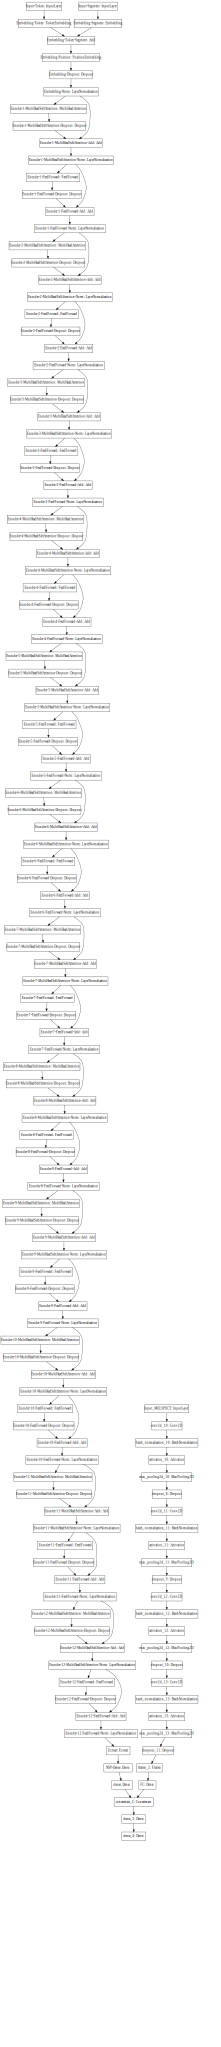

In [29]:
SVG(model_to_dot(totalModel, dpi=65).create(prog='dot', format='svg'))